In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
detectors_run4 = pd.read_excel("cms_system_140.xlsx", sheet_name="Detectors")
triggers_run4 = pd.read_excel("cms_system_140.xlsx", sheet_name="Triggers")

In [3]:
detectors_run4

,Category,Detector,Data (bytes),Sample Rate,True Pass,True Discard,False Pass (alpha),False Discard (beta),Compression,PU 140,PU 200
0,Tracking,Inner Tracker,1010000,40000000,1,0,0,0,0,1.010,1.440
1,Tracking,Outer Tracker PS,500000,40000000,1,0,0,0,0,0.500,0.720
2,Tracking,Outer Tracker 2S,300000,40000000,1,0,0,0,0,0.300,0.430
3,Tracking,Track Finder TPG,10000,40000000,1,0,0,0,0,0.010,0.010
4,Timing,MIP Timing BTL,170000,40000000,1,0,0,0,0,0.170,0.240
5,Timing,MIP Timing ETL,310000,40000000,1,0,0,0,0,0.310,0.440
6,Calorimetry,ECAL Barrel,420000,40000000,1,0,0,0,0,0.420,0.600
7,Calorimetry,HCAL Barrel,240000,40000000,1,0,0,0,0,0.240,0.240
8,Calorimetry,HCAL HO,30000,40000000,1,0,0,0,0,0.030,0.030
9,Calorimetry,HCAL HF,60000,40000000,1,0,0,0,0,0.060,0.060


In [4]:
triggers_run4

,Output,Name,Data (bytes),True Pass,True Discard,False Pass (alpha),False Discard (beta),Compression,PU 140,PU 200
0,Intermediate,Tracking,0,1,0,0,0,0,NaN,NaN
1,Intermediate,Timing,0,1,0,0,0,0,NaN,NaN
2,Intermediate,Calorimetry,0,1,0,0,0,0,NaN,NaN
3,Intermediate,Muon,0,1,0,0,0,0,NaN,NaN
4,Global,Intermediate,260000,1,399,0,0,0,0.26,0.26
5,Disk,Global,0,1,19,0,0,0,NaN,NaN
6,NaN,Disk,0,1,0,0,0,0,NaN,NaN


In [5]:
def entry_to_confusion(entry: pd.core.series.Series):
    tp = entry["True Pass"]
    td = entry["True Discard"]
    fp = entry["False Pass (alpha)"]
    fd = entry["False Discard (beta)"]

    confusion = np.array([[td, fd], [fp, tp]])
    return confusion

In [6]:
def detectors(detector_data: pd.DataFrame):
    n = len(detector_data)
    nodes = []
    edges = []

    for i in range(n):
        detector = detector_data.iloc[i]
        name = detector["Detector"]
        system = detector["Category"]
        properties = {
                      "sample data": detector["Data (bytes)"],
                      "sample rate": detector["Sample Rate"],
                      "error matrix": entry_to_confusion(detector),
                      "reduction": 1.0 - detector["Compression"],
                      "complexity": lambda x: x,
                      }
        nodes.append((name, properties))
        edges.append((name, system))

    return nodes, edges

In [7]:
def triggers(trigger_data: pd.DataFrame):
    n = len(trigger_data)
    edges = []
    triggers = []

    for i in range(n):
        trigger = trigger_data.iloc[i]
        name = trigger["Name"]
        properties = {
            "error matrix": entry_to_confusion(trigger),
            "reduction": 1.0 - trigger["Compression"],
            "sample data": trigger["Data (bytes)"],
        }
        triggers.append((name, properties))

        output = trigger["Output"]
        if not pd.isna(output):
            edge = (trigger["Name"], trigger["Output"])
            edges.append(edge)

    return triggers, edges

In [8]:
def identify_root(graph: nx.classes.digraph):
    od = list(graph.out_degree)
    roots = list(filter(lambda x: x[1] == 0, od))
    assert len(roots) == 1, "More than 1 root identified"
    return roots[0]


In [9]:
def construct_graph(detector_data: pd.DataFrame, trigger_data: pd.DataFrame):
    g = nx.DiGraph()
    #add the nodes for detectors
    detector_nodes, detector_edges = detectors(detector_data)
    g.add_nodes_from(detector_nodes)
    #add the nodes for trigger systems
    trigger_nodes, trigger_edges = triggers(trigger_data)
    g.add_nodes_from(trigger_nodes)
    #connect the systems
    g.add_edges_from(detector_edges)
    g.add_edges_from(trigger_edges)
    #identify the final (root) node
    root = identify_root(g)
    g.graph["Root Node"] = root[0]
    return g

    globals = measure(g)
    for k, v in globals:
        g[k] = v

    return g, globals


In [10]:
cms_pu140 = construct_graph(detectors_run4, triggers_run4)

In [11]:
cms_pu140.edges

OutEdgeView([('Inner Tracker', 'Tracking'), ('Outer Tracker PS', 'Tracking'), ('Outer Tracker 2S', 'Tracking'), ('Track Finder TPG', 'Tracking'), ('MIP Timing BTL', 'Timing'), ('MIP Timing ETL', 'Timing'), ('ECAL Barrel', 'Calorimetry'), ('HCAL Barrel', 'Calorimetry'), ('HCAL HO', 'Calorimetry'), ('HCAL HF', 'Calorimetry'), ('HGCAL', 'Calorimetry'), ('HGCAL TPG Stage1', 'Calorimetry'), ('HGCAL TPG Stage2', 'Calorimetry'), ('Muon DT', 'Muon'), ('Muon CSC', 'Muon'), ('Muon GEM GE1', 'Muon'), ('Muon GEM GE2', 'Muon'), ('Muon GEM ME0', 'Muon'), ('Muon RPC', 'Muon'), ('Tracking', 'Intermediate'), ('Timing', 'Intermediate'), ('Calorimetry', 'Intermediate'), ('Muon', 'Intermediate'), ('Intermediate', 'Global'), ('Global', 'Disk')])

In [12]:
cms_pu140.edges[("Inner Tracker", "Tracking")]

{}

In [13]:
list(cms_pu140.nodes)

['Inner Tracker',
 'Outer Tracker PS',
 'Outer Tracker 2S',
 'Track Finder TPG',
 'MIP Timing BTL',
 'MIP Timing ETL',
 'ECAL Barrel',
 'HCAL Barrel',
 'HCAL HO',
 'HCAL HF',
 'HGCAL',
 'HGCAL TPG Stage1',
 'HGCAL TPG Stage2',
 'Muon DT',
 'Muon CSC',
 'Muon GEM GE1',
 'Muon GEM GE2',
 'Muon GEM ME0',
 'Muon RPC',
 'Tracking',
 'Timing',
 'Calorimetry',
 'Muon',
 'Intermediate',
 'Global',
 'Disk']

In [14]:
cms_pu140.graph["Root Node"]

'Disk'

In [15]:
cms_pu140.nodes["Inner Tracker"]

{'sample data': 1010000,
 'sample rate': 40000000,
 'error matrix': array([[0, 0],
        [0, 1]]),
 'reduction': 1.0,
 'complexity': <function __main__.detectors.<locals>.<lambda>(x)>}

In [16]:
cms_pu140.edges[("Inner Tracker", "Tracking")]

{}

In [17]:
cms_pu140.nodes["Tracking"]

{'error matrix': array([[0, 0],
        [0, 1]]),
 'reduction': 1.0,
 'sample data': 0}

In [18]:
cms_pu140.edges[("Tracking", "Intermediate")]

{}

In [19]:
cms_pu140.nodes["Disk"]

{'error matrix': array([[0, 0],
        [0, 1]]),
 'reduction': 1.0,
 'sample data': 0}

In [20]:
def update_throughput(graph: nx.classes.digraph):
    graph = graph.copy()
    #call the recursive update function on the root node
    throughput_call(graph, graph.graph["Root Node"])
    return graph
    

In [21]:
def message_size(graph: nx.classes.digraph, node: str):
    """
    Return the total size of a message processed by a node
    """
    inputs = list(graph.predecessors(node))
    input_data = sum([message_size(graph, n) for n in inputs])
    this_node = graph.nodes[node]
    if "sample data" in this_node:
        total = input_data + this_node["sample data"]
    else:
        total = input_data

    total = total * this_node["reduction"]
    this_node["message size"] = total
    return total


In [22]:
def classifier_rate(error_matrix: np.ndarray):
        """
        Return the negative / positive classification rate from an error matrix
        """
        rates = np.einsum("ab,a -> a", error_matrix, np.array([1, 1]))
        return rates / rates.sum()

In [23]:
classifier_rate(cms_pu140.nodes["Intermediate"]["error matrix"]) * 40e6

array([39900000.,   100000.])

In [24]:
def message_rate(graph: nx.classes.digraph, node: str):
    """
    Return the rate of messages produced by a node
    """
    this_node = graph.nodes[node]
    if "sample rate" in this_node:
        #get the sampling rate of a detector
        input_rate = this_node["sample rate"]
    else:
        #or take the maximum rate of the inputs
        inputs = list(graph.predecessors(node))
        assert len(inputs) > 0, "Missing sample rate from detector or isolated node"
        input_rate = max([message_rate(graph, n) for n in inputs])
    
    output_rate = classifier_rate(this_node["error matrix"])[1] * input_rate
    this_node["message rate"] = output_rate
    return output_rate 

In [26]:
g1 = cms_pu140.copy()

In [27]:
g2 = message_size(g1, "Disk")

In [28]:
g2

6093000.0

In [29]:
message_rate(g1, "Disk")

5000.0

In [ ]:
def link_throughput(graph: nx.classes.digraph, node: str):
    """
    Return the rate of messages produced by a node and update its input edges
    to show their sustained data rates
    """
    inputs = list(graph.predecessors(node))
    rates = [link_throughput(graph, n) for n in inputs]
    throughput = [rates[i] * graph.nodes[n]["message size"] for (i,n) in enumerate(inputs)]
    for n in inputs:
        edge = (n, node)
        graph.edges[edge]["throughput"] = 

    

    def sum_outputs(error_matrix: np.ndarray):
        return np.einsum("ab,a -> a", error_matrix, np.array([0, 1])).sum()

    def output_rate(sample_rate, error_matrix: np.ndarray):
        return sample_rate * (error_matrix / error_matrix.sum())

    return total


In [25]:
g1.nodes["Inner Tracker"]

{'sample data': 1010000,
 'error matrix': array([[       0,        0],
        [       0, 40000000]]),
 'reduction': 1.0,
 'complexity': <function __main__.detectors.<locals>.<lambda>(x)>,
 'message size': 1010000}

In [27]:
g2 / 1e6

6.093

In [ ]:
def message_size(graph: nx.classes.digraph, node: str):
    inputs = list(graph.predecessors(node))
    input_data = sum([message_size(graph, n) for n in inputs])
    this_node = graph.nodes[node]
    if "sample data" in this_node:
        total = input_data + this_node["sample data"]
    else:
        total = input_data

    this_node["message size"] = total
    return total


In [77]:
def throughput_call(graph: nx.classes.digraph, node: str):
    print(node)
    inputs = list(graph.predecessors(node))
    this_node = graph.nodes[node]

    

    this_node["total data"] = 0
    if len(inputs) > 0:
        #set the initial sampling rate
        input_rate = 0

        for in_node in inputs:
            link = (in_node, node)
            #how much data does the input produce? recursive call to inputs
            throughput_call(graph, in_node)
            input_node = graph.nodes[in_node]
            data = input_node["sample data"]
            #update the amount of data transported over links
            sample_rate = sum_outputs(input_node["error matrix"])
            graph.edges[link]["sample rate"] = sample_rate
            graph.edges[link]["data rate"] = sample_rate * data
            #take the maximum input rate as the sampling rate
            if sample_rate > input_rate:
                input_rate = sample_rate
            
            this_node["total data"] += data
            print(this_node["total data"])
        
        if "error matrix" in this_node:
            this_node["sample rate"] = output_rate(input_rate, this_node["error matrix"])
        else:
            this_node["sample rate"] = input_rate
        print("Done")
    else:
        #if there are no inputs, this is a source of the data
        sample_rate = sum_outputs(graph.nodes[node]["error matrix"])
        this_node["sample rate"] = sample_rate
    
    #how much data is produced at this node?
    if "sample data" in this_node:
        this_node["total data"] += this_node["sample data"]

In [78]:
g2 = update_throughput(cms_pu140)

Disk
Global
Intermediate
Tracking
Inner Tracker
1440000
Outer Tracker PS
2160000
Outer Tracker 2S
2590000
Track Finder TPG
2600000
Done
0
Timing
MIP Timing BTL
240000
MIP Timing ETL
680000
Done
0
Calorimetry
ECAL Barrel
600000
HCAL Barrel
840000
HCAL HO
870000
HCAL HF
930000
HGCAL
3930000
HGCAL TPG Stage1
4080000
HGCAL TPG Stage2
4130000
Done
0
Muon
Muon DT
150000
Muon CSC
620000
Muon GEM GE1
623000
Muon GEM GE2
625000
Muon GEM ME0
745000
Muon RPC
755000
Done
0
Done
260000
Done
0
Done


In [71]:
g2.nodes["Tracking"]

{'error matrix': array([[0, 0],
        [0, 1]]),
 'reduction': 1.0,
 'sample data': 0,
 'total data': 2600000,
 'sample rate': array([[       0.,        0.],
        [       0., 40000000.]])}

In [73]:
g2.nodes["Inner Tracker"]

{'sample data': 1440000,
 'error matrix': array([[       0,        0],
        [       0, 40000000]]),
 'reduction': 1.0,
 'complexity': <function __main__.detectors.<locals>.<lambda>(x)>,
 'total data': 1440000,
 'sample rate': 40000000}

In [74]:
g2.nodes["Tracking"]

{'error matrix': array([[0, 0],
        [0, 1]]),
 'reduction': 1.0,
 'sample data': 0,
 'total data': 2600000,
 'sample rate': array([[       0.,        0.],
        [       0., 40000000.]])}

In [75]:
g2.nodes["Calorimetry"]

{'error matrix': array([[0, 0],
        [0, 1]]),
 'reduction': 1.0,
 'sample data': 0,
 'total data': 4130000,
 'sample rate': array([[       0.,        0.],
        [       0., 40000000.]])}

In [76]:
g2.nodes["Intermediate"]

{'error matrix': array([[399,   0],
        [  0,   1]]),
 'reduction': 1.0,
 'sample data': 260000,
 'total data': 260000,
 'sample rate': array([[0.9975, 0.    ],
        [0.    , 0.0025]])}

In [20]:
cms_pu140.nodes["Inner Tracker"]["sample data"]

1440000

In [19]:
cms_pu140.nodes["Inner Tracker"]

{'sample data': 1440000,
 'error matrix': array([[       0,        0],
        [       0, 40000000]]),
 'reduction': 1.0,
 'complexity': <function __main__.detectors.<locals>.<lambda>(x)>}

In [20]:
cms_pu140.nodes["Intermediate"]

{'error matrix': array([[399,   0],
        [  0,   1]]),
 'reduction': 1.0,
 'sample data': 260000}

In [21]:
def rates(error_matrix):
    return np.sum(error_matrix, axis=1)

In [22]:
rates(cms_pu140.nodes["Intermediate"]["error matrix"])

array([399,   1])

In [25]:
rates(cms_pu140.nodes["Inner Tracker"]["error matrix"])[1]

40000000

In [35]:
cms_pu140.graph

{'Root Node': 'Disk'}

In [14]:
cms_pu140.nodes["Inner Tracker"]

{'sample data': 1440000,
 'error matrix': array([[       0,        0],
        [       0, 40000000]]),
 'reduction': 1.0,
 'complexity': <function __main__.detectors.<locals>.<lambda>(x)>}

In [15]:
cms_pu140.edges


OutEdgeView([('Inner Tracker', 'Tracking'), ('Outer Tracker PS', 'Tracking'), ('Outer Tracker 2S', 'Tracking'), ('Track Finder TPG', 'Tracking'), ('MIP Timing BTL', 'Timing'), ('MIP Timing ETL', 'Timing'), ('ECAL Barrel', 'Calorimetry'), ('HCAL Barrel', 'Calorimetry'), ('HCAL HO', 'Calorimetry'), ('HCAL HF', 'Calorimetry'), ('HGCAL', 'Calorimetry'), ('HGCAL TPG Stage1', 'Calorimetry'), ('HGCAL TPG Stage2', 'Calorimetry'), ('Muon DT', 'Muon'), ('Muon CSC', 'Muon'), ('Muon GEM GE1', 'Muon'), ('Muon GEM GE2', 'Muon'), ('Muon GEM ME0', 'Muon'), ('Muon RPC', 'Muon'), ('Tracking', 'Intermediate'), ('Timing', 'Intermediate'), ('Calorimetry', 'Intermediate'), ('Muon', 'Intermediate'), ('Intermediate', 'Global'), ('Global', 'Disk')])

In [16]:
cms_pu140["Tracking"]

AtlasView({'Intermediate': {}})

In [17]:
list(cms_pu140.predecessors("Tracking"))

['Inner Tracker', 'Outer Tracker PS', 'Outer Tracker 2S', 'Track Finder TPG']

In [40]:
list(cms_pu140.predecessors("Disk"))

['Global']

In [41]:
list(cms_pu140.predecessors("Outer Tracker PS"))

[]

In [18]:
cms_pu140["Intermediate"]

AtlasView({'Global': {}})

In [19]:
cms_pu140["Global"]

AtlasView({'Disk': {}})

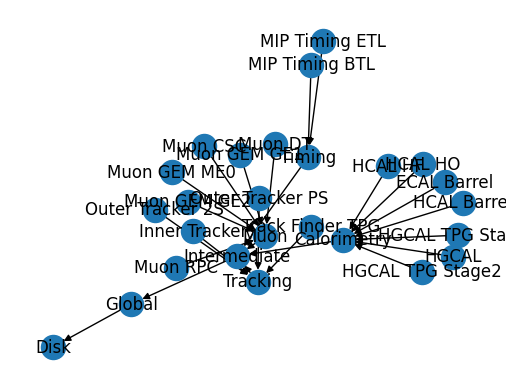

In [22]:
subax1 = plt.subplot(111)
nx.draw(cms_pu140, with_labels=True)